# Model: Decision Tree Classifier

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

In [83]:
# Read from CSV file
df = pd.read_csv('Data/cleaned_data.csv')

<hr>

### Splitting of Data Set
- Total records: 70692
- Validation Set: 13% (9190 records)
- Unseen Set: 4% (2830 Records)
- Training and Test set: 83% (58672 Records)

In [84]:
X = df.drop('Diabetes_binary', axis=1) # features
y = df['Diabetes_binary']

# Split the dataset into training and test sets
training_set, test_set, y_train, test_labels = train_test_split(X, y, test_size=0.13, random_state=424, shuffle=True)

# Split the training set into validation and remaining training sets
training_set, validation_set, y_train, validation_labels = train_test_split(training_set, y_train, test_size=0.1131, random_state=424, shuffle=True)

# Split the remaining training set into an unseen set
training_set, unseen_set, train_labels, unseen_labels = train_test_split(training_set, y_train, test_size=0.0296, random_state=424, shuffle=True)


In [85]:
remaining_data, val_data = train_test_split(df, test_size=0.13, random_state=424, shuffle=True)
print(df.shape)
print(val_data.shape)

train_test_data, unseen_data = train_test_split(remaining_data, test_size=0.046, random_state=424, shuffle=True)
print(unseen_data.shape)
print(train_test_data.shape)

(70692, 23)
(9190, 23)
(2830, 23)
(58672, 23)


In [86]:
train_test_data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,BMI_bins
35092,0.0,0.0,0.0,1.0,30.0,0.0,0.0,0.0,1.0,0.0,...,0.0,3.0,5.0,0.0,0.0,0.0,8.0,5.0,5.0,3
48613,1.0,0.0,0.0,1.0,23.0,1.0,0.0,0.0,1.0,0.0,...,0.0,3.0,30.0,5.0,0.0,1.0,11.0,4.0,1.0,1
70651,1.0,0.0,1.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,0.0,3.0,0.0,1.0,5.0,6.0,2.0,3
5900,0.0,0.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,9.0,6.0,8.0,2
44692,1.0,1.0,1.0,1.0,35.0,0.0,0.0,0.0,1.0,1.0,...,0.0,3.0,2.0,0.0,0.0,0.0,7.0,4.0,5.0,3


In [87]:
unseen_data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,BMI_bins
13146,0.0,1.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,0.0,5.0,30.0,10.0,0.0,0.0,7.0,4.0,6.0,2
38090,1.0,1.0,1.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,25.0,30.0,1.0,1.0,7.0,5.0,8.0,1
21176,0.0,0.0,0.0,1.0,23.0,1.0,0.0,0.0,1.0,0.0,...,0.0,3.0,2.0,2.0,0.0,1.0,10.0,3.0,3.0,1
10688,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,4.0,5.0,6.0,2
14089,0.0,0.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4.0,10.0,4.0,0.0,1.0,3.0,6.0,7.0,2


In [88]:
val_data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,BMI_bins
38170,1.0,0.0,0.0,1.0,33.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,0.0,0.0,0.0,0.0,5.0,5.0,1.0,3
26096,0.0,0.0,1.0,1.0,33.0,0.0,0.0,0.0,1.0,1.0,...,0.0,3.0,3.0,3.0,1.0,0.0,10.0,6.0,7.0,3
29923,0.0,0.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,8.0,6.0,8.0,1
68491,1.0,1.0,1.0,1.0,21.0,0.0,0.0,1.0,1.0,0.0,...,1.0,4.0,15.0,20.0,0.0,1.0,5.0,5.0,1.0,1
40501,1.0,1.0,0.0,1.0,45.0,1.0,0.0,1.0,0.0,1.0,...,0.0,2.0,7.0,0.0,0.0,0.0,7.0,4.0,7.0,3


- training_set : train_labels
- test_set : test_labels
- validation_set : validation_labels
- unseen_set : unseen_labels

<hr>
<hr>

### Correlation Coefficient Results
This variables have more correlated with the target variable Diabetes_binary - Greater than 0.25
- Diabetes_binary and HighBP have a correlation coefficient of 0.3815155489073117
- Diabetes_binary and HighChol have a correlation coefficient of 0.28921280708865016
- Diabetes_binary and BMI have a correlation coefficient of 0.29337274476103575
- Diabetes_binary and GenHlth have a correlation coefficient of 0.4076115984949182
- Diabetes_binary and DiffWalk have a correlation coefficient of 0.272646006159808
- Diabetes_binary and Age have a correlation coefficient of 0.27873806628188813
- Diabetes_binary and BMI_bins have a correlation coefficient of 0.2995782127672782

<hr>

### Model Evaluation (Entropy & Gini)

##### Variables Used : Top 6 variables based on <u>Correlation Cofficient</u>
['HighBP', 'HighChol', 'GenHlth', 'DiffWalk', 'Age','BMI_bins']


##### Decision Tree Classifier (Entropy)

In [89]:
# Create K-Fold splitter for 10 folds
num_of_folds = 10
skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=424)


In [90]:
# can tweak the features as needed
features = ['HighBP', 'HighChol', 'GenHlth', 'DiffWalk', 'Age','BMI_bins']
X = train_test_data[features]
y = train_test_data["Diabetes_binary"]

In [91]:
# Create Decision Tree Classifier entropy model object
dtree = DecisionTreeClassifier(criterion = 'entropy', random_state = 424)

In [92]:
# List of accuracy for each fold
k_fold_accuracy = []
k_fold_classification_error = []
k_fold_sensitivity = []
k_fold_precision = []
k_fold_specificity = []
k_fold_f1_score = []

auc_roc_scores = []
fpr_values = []
tpr_values = []


10


Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

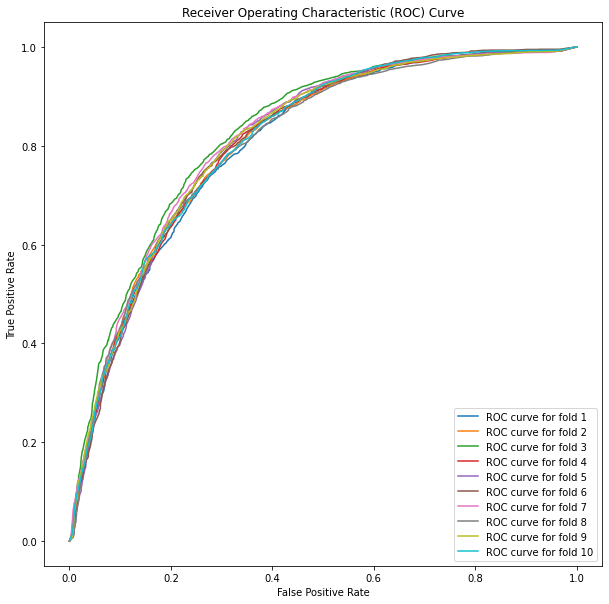

In [93]:
plt.figure(figsize=(10, 10))
# Iterate through each fold and calculate the accuracy for each fold
fold = 1

for train_index, test_index in skf.split(X,y):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit/predict on train/validation set
    y_pred = dtree.fit(X_train, y_train).predict(X_test)
    # -----------------------------------------------------------
    
    #confusion Matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)
    
    # Access specific values of confusion matix using [row, column]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    # Calculate accuracy for the fold and append it
    accuracy = metrics.accuracy_score(y_test, y_pred)
    k_fold_accuracy.append(round(accuracy, 4))
    #print('The accuracy for each fold is:', k_fold_accuracy)
    
    # Calculate classification error derived from accuracy (we minus it against 1) for the fold and append it
    classification_error = 1 - accuracy
    k_fold_classification_error.append(round(classification_error, 4))

    # Calculate sensitivity for the fold and append it
    sensitivity = metrics.recall_score(y_test, y_pred)
    k_fold_sensitivity.append(round(sensitivity, 4))

    # Calculate precision for the fold and append it
    precision = metrics.precision_score(y_test, y_pred)
    k_fold_precision.append(round(precision, 4))
    
    # Calculate specificity for the fold and append it
    specificity = TN / (TN + FP)
    k_fold_specificity.append(round(specificity, 4))
    
    # Calculate f1_score for the fold and append it
    f1_score = (2 * sensitivity * precision) / (sensitivity + precision)
    k_fold_f1_score.append(round(f1_score, 4))
    
    #--------------------------------------------------------------------------------------------------
    
    y_pred_proba = dtree.predict_proba(X_test)[:, 1]

    
    # Calculate the AUC-ROC score for this fold
    auc_roc_score = roc_auc_score(y_test, y_pred_proba)
    auc_roc_scores.append(auc_roc_score)

    # Calculate the fpr/tpr values for the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    fpr_values.append(fpr)
    tpr_values.append(tpr)
    
    
    plt.plot(fpr, tpr, label=f"ROC curve for fold {fold}")    

    fold += 1
    
print(len(auc_roc_scores))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) Curve')

In [94]:
# Calculate the (1) average false positive rate, (2) average true positive rate

# Get the maximum length of the arrays in the list
max_length_fpr = max(len(a) for a in fpr_values)
max_length_tpr = max(len(a) for a in tpr_values)

# Pad each array in the list with zeros so that they have the same length
padded_fpr = np.array([np.pad(a, (0, max_length_fpr - len(a)), mode='constant') for a in fpr_values])
padded_tpr = np.array([np.pad(a, (0, max_length_tpr - len(a)), mode='constant') for a in tpr_values])

weights = [len(test_index) / len(y) for _, test_index in skf.split(X,y)]
avg_auc_roc = np.average(auc_roc_scores, weights=weights, axis=0)
avg_fpr_value = np.average(padded_fpr, weights=weights, axis=0)
avg_tpr_value = np.average(padded_tpr, weights=weights, axis=0)

# Plot AUC using area chart
fig = px.area(
    x = avg_fpr_value, y = avg_tpr_value,
    title = f'ROC Curve (AUC={avg_auc_roc:.4f})',
    labels = dict(x = 'Average False Positive Rate', y = 'Average True Positive Rate'),
    width = 700, height = 700
)

# This part adds formatting & plots the dashed line at AUC=0.5 
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [95]:
x_axis = [i for i in range(1, num_of_folds + 1)]
fig = px.scatter( x = x_axis, y = auc_roc_scores,
                 labels = {"x": "K-Fold", "y": "AUC Score"},
                 trendline = 'ols',
                 title = 'AUC Values for the the each K-Fold' # add title parameter
)

fig.show()

In [96]:
print('The average accuracy is:', statistics.mean(k_fold_accuracy))
print('The average classification error is:', statistics.mean(k_fold_classification_error))
print('The average sensitivity is:', statistics.mean(k_fold_sensitivity))
print('The average precision is:', statistics.mean(k_fold_precision))
print('The average specificity is:', statistics.mean(k_fold_specificity))
print('The average f1 score is:', statistics.mean(k_fold_f1_score))


The average accuracy is: 0.739
The average classification error is: 0.261
The average sensitivity is: 0.77279
The average precision is: 0.7239599999999999
The average specificity is: 0.70519
The average f1 score is: 0.74752


##### Decision Tree Classifier (Gini)

In [97]:
# Create K-Fold splitter for 10 folds
num_of_folds = 10
skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=424)


In [98]:
# can tweak the features as needed
features = ['HighBP', 'HighChol', 'GenHlth', 'DiffWalk', 'Age','BMI_bins']
X = train_test_data[features]
y = train_test_data["Diabetes_binary"]

In [99]:
# Create Decision Tree Classifier gini model object
dtree = DecisionTreeClassifier(criterion = 'gini', random_state = 424)

In [100]:
# List of accuracy for each fold
k_fold_accuracy = []
k_fold_classification_error = []
k_fold_sensitivity = []
k_fold_precision = []
k_fold_specificity = []
k_fold_f1_score = []

auc_roc_scores = []
fpr_values = []
tpr_values = []


10


Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

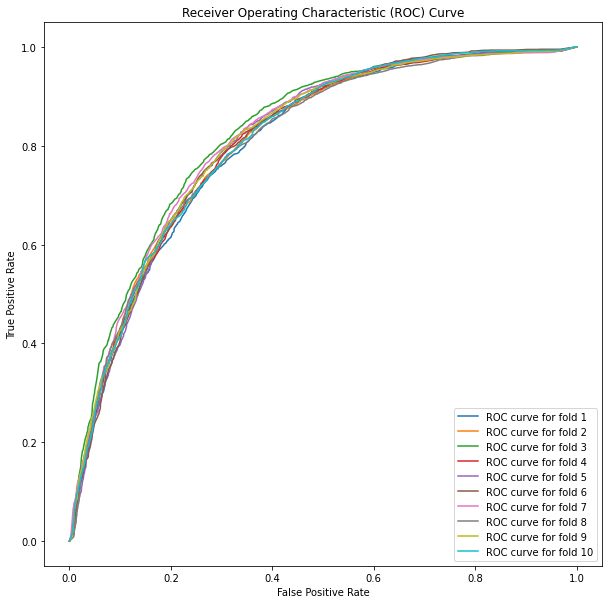

In [101]:
plt.figure(figsize=(10, 10))
# Iterate through each fold and calculate the accuracy for each fold
fold = 1

for train_index, test_index in skf.split(X,y):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit/predict on train/validation set
    y_pred = dtree.fit(X_train, y_train).predict(X_test)
    # -----------------------------------------------------------
    
    #confusion Matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)
    
    # Access specific values of confusion matix using [row, column]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    # Calculate accuracy for the fold and append it
    accuracy = metrics.accuracy_score(y_test, y_pred)
    k_fold_accuracy.append(round(accuracy, 4))
    #print('The accuracy for each fold is:', k_fold_accuracy)
    
    # Calculate classification error derived from accuracy (we minus it against 1) for the fold and append it
    classification_error = 1 - accuracy
    k_fold_classification_error.append(round(classification_error, 4))

    # Calculate sensitivity for the fold and append it
    sensitivity = metrics.recall_score(y_test, y_pred)
    k_fold_sensitivity.append(round(sensitivity, 4))

    # Calculate precision for the fold and append it
    precision = metrics.precision_score(y_test, y_pred)
    k_fold_precision.append(round(precision, 4))
    
    # Calculate specificity for the fold and append it
    specificity = TN / (TN + FP)
    k_fold_specificity.append(round(specificity, 4))
    
    # Calculate f1_score for the fold and append it
    f1_score = (2 * sensitivity * precision) / (sensitivity + precision)
    k_fold_f1_score.append(round(f1_score, 4))
    
    #--------------------------------------------------------------------------------------------------
    
    y_pred_proba = dtree.predict_proba(X_test)[:, 1]

    
    # Calculate the AUC-ROC score for this fold
    auc_roc_score = roc_auc_score(y_test, y_pred_proba)
    auc_roc_scores.append(auc_roc_score)

    # Calculate the fpr/tpr values for the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    fpr_values.append(fpr)
    tpr_values.append(tpr)
    
    
    plt.plot(fpr, tpr, label=f"ROC curve for fold {fold}")    

    fold += 1
    
print(len(auc_roc_scores))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) Curve')

In [102]:
# Calculate the (1) average false positive rate, (2) average true positive rate

# Get the maximum length of the arrays in the list
max_length_fpr = max(len(a) for a in fpr_values)
max_length_tpr = max(len(a) for a in tpr_values)

# Pad each array in the list with zeros so that they have the same length
padded_fpr = np.array([np.pad(a, (0, max_length_fpr - len(a)), mode='constant') for a in fpr_values])
padded_tpr = np.array([np.pad(a, (0, max_length_tpr - len(a)), mode='constant') for a in tpr_values])

weights = [len(test_index) / len(y) for _, test_index in skf.split(X,y)]
avg_auc_roc = np.average(auc_roc_scores, weights=weights, axis=0)
avg_fpr_value = np.average(padded_fpr, weights=weights, axis=0)
avg_tpr_value = np.average(padded_tpr, weights=weights, axis=0)

# Plot AUC using area chart
fig = px.area(
    x = avg_fpr_value, y = avg_tpr_value,
    title = f'ROC Curve (AUC={avg_auc_roc:.4f})',
    labels = dict(x = 'Average False Positive Rate', y = 'Average True Positive Rate'),
    width = 700, height = 700
)

# This part adds formatting & plots the dashed line at AUC=0.5 
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [103]:
x_axis = [i for i in range(1, num_of_folds + 1)]
fig = px.scatter( x = x_axis, y = auc_roc_scores,
                 labels = {"x": "K-Fold", "y": "AUC Score"},
                 trendline = 'ols',
                 title = 'AUC Values for the the each K-Fold' # add title parameter
)

fig.show()

In [104]:
print('The average accuracy is:', statistics.mean(k_fold_accuracy))
print('The average classification error is:', statistics.mean(k_fold_classification_error))
print('The average sensitivity is:', statistics.mean(k_fold_sensitivity))
print('The average precision is:', statistics.mean(k_fold_precision))
print('The average specificity is:', statistics.mean(k_fold_specificity))
print('The average f1 score is:', statistics.mean(k_fold_f1_score))


The average accuracy is: 0.73892
The average classification error is: 0.26108
The average sensitivity is: 0.77282
The average precision is: 0.72381
The average specificity is: 0.70497
The average f1 score is: 0.74748


Comparing both the Entropy and Gini side to side, since sensitivity is what we are prioritising, thus the best model to use would be Decision Tree Classifier Gini Model.

<hr>
<hr>

## Feature selection
### Method 1: Recursive Feature Elimination with Cross-Validation
 It is a feature selection algorithm that combines both recursive feature elimination (RFE) and cross-validation (CV) techniques to identify the optimal subset of features for a given predictive model.
 
It works by recursively removing features from the original feature set and training a model on the remaining features until a specified number of features is reached. At each iteration, the algorithm uses cross-validation to estimate the performance of the model and decides which feature to eliminate based on its contribution to the model's performance.

In [107]:
from sklearn.feature_selection import RFECV

X = train_test_data[['HighBP', 'HighChol', 'CholCheck', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI_bins']]
y = train_test_data["Diabetes_binary"]

# Create Decision Tree Classifier gini model object
dtree = DecisionTreeClassifier(criterion = 'gini', random_state = 424)

# Create an RFE object with the CatBoost model and number of features to select
rfecv = RFECV(dtree, cv=5, scoring='f1_weighted')

# Fit the RFE object on your dataset
rfecv.fit(X, y)

print("Feature ranking: ", rfecv.ranking_)

# Get the names of the optimal features
RFECV_selected = []
for index in range(len(X.columns)):
    if rfecv.ranking_[index] == 1:
        RFECV_selected.append(X.columns[index])

RFECV_selected



Feature ranking:  [ 1 13 19  7 16 14  8  6 10 17 18 15  1  3  2 12 11  1  5  4  9]


['HighBP', 'GenHlth', 'Age']

In [108]:
selected_features_indices = np.where(rfecv.support_ == True)[0]
selected_features = X.columns[selected_features_indices]
print("Selected features:", selected_features)

Selected features: Index(['HighBP', 'GenHlth', 'Age'], dtype='object')


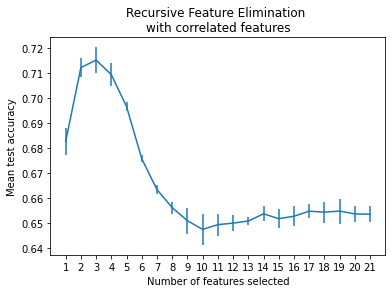

In [109]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.xticks(range(1,22))
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

##### RFECV Evaluation
Based on RFECV, the following variables have all been ranked 1. ['HighBP', 'GenHlth', 'Age']


But after plotting the mean accuracy against the number of features selected, we can also see that it plateaus at <u><b>3 features</b></u>
<br>
<b>Optimal Number of features: 3 </b>

### Method 2: Recursive Feature Elimination
It is a feature selection algorithm that selects the most important features from a given dataset by recursively eliminating less important features.

The RFE algorithm works by first training a model on the entire feature set and ranking the features based on their importance. It then eliminates the least important feature from the set and repeats the process of training and ranking until a specified number of features is reached. At each iteration, the algorithm evaluates the performance of the model using the remaining features and decides which feature to eliminate based on its contribution to the model's performance.

In [113]:
X = train_test_data[['HighBP', 'HighChol', 'CholCheck', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI_bins']]
y = train_test_data["Diabetes_binary"]

##### Select 3 Features

In [114]:
# Create Decision Tree Classifier gini model object
dtree = DecisionTreeClassifier(criterion = 'gini', random_state = 424)
# Create an RFE object with the Decision Tree Classifier gini model and number of features to select
rfe = RFE(dtree, n_features_to_select=3)

# Fit the RFE object on your dataset
fit = rfe.fit(X, y)

In [115]:
# Get the selected features
selected_features = X.columns[rfe.support_]

print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Selected Features: %s" % selected_features)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [ True False False False False False False False False False False False
  True False False False False  True False False False]
Selected Features: Index(['HighBP', 'GenHlth', 'Age'], dtype='object')
Feature Ranking: [ 1 13 19  7 16 14  8  6 10 17 18 15  1  3  2 12 11  1  5  4  9]


##### Select 4 Features

In [116]:
# Create Decision Tree Classifier gini model object
dtree = DecisionTreeClassifier(criterion = 'gini', random_state = 424)
# Create an RFE object with the Decision Tree Classifier gini model and number of features to select
rfe = RFE(dtree, n_features_to_select=4)

# Fit the RFE object on your dataset
fit = rfe.fit(X, y)

In [117]:
# Get the selected features
selected_features = X.columns[rfe.support_]

print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Selected Features: %s" % selected_features)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 4
Selected Features: [ True False False False False False False False False False False False
  True False  True False False  True False False False]
Selected Features: Index(['HighBP', 'GenHlth', 'PhysHlth', 'Age'], dtype='object')
Feature Ranking: [ 1 12 18  6 15 13  7  5  9 16 17 14  1  2  1 11 10  1  4  3  8]


##### Select 5 Features

In [118]:
# Create Decision Tree Classifier gini model object
dtree = DecisionTreeClassifier(criterion = 'gini', random_state = 424)
# Create an RFE object with the Decision Tree Classifier gini model and number of features to select
rfe = RFE(dtree, n_features_to_select=5)

# Fit the RFE object on your dataset
fit = rfe.fit(X, y)

In [119]:
# Get the selected features
selected_features = X.columns[rfe.support_]

print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Selected Features: %s" % selected_features)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [ True False False False False False False False False False False False
  True  True  True False False  True False False False]
Selected Features: Index(['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age'], dtype='object')
Feature Ranking: [ 1 11 17  5 14 12  6  4  8 15 16 13  1  1  1 10  9  1  3  2  7]


##### Select 6 Features

In [120]:
# Create Decision Tree Classifier gini model object
dtree = DecisionTreeClassifier(criterion = 'gini', random_state = 424)
# Create an RFE object with the Decision Tree Classifier gini model and number of features to select
rfe = RFE(dtree, n_features_to_select=6)

# Fit the RFE object on your dataset
fit = rfe.fit(X, y)

In [121]:
# Get the selected features
selected_features = X.columns[rfe.support_]

print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Selected Features: %s" % selected_features)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 6
Selected Features: [ True False False False False False False False False False False False
  True  True  True False False  True False  True False]
Selected Features: Index(['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Income'], dtype='object')
Feature Ranking: [ 1 10 16  4 13 11  5  3  7 14 15 12  1  1  1  9  8  1  2  1  6]


##### Select 7 Features

In [122]:
# Create Decision Tree Classifier gini model object
dtree = DecisionTreeClassifier(criterion = 'gini', random_state = 424)
# Create an RFE object with the Decision Tree Classifier gini model and number of features to select
rfe = RFE(dtree, n_features_to_select=7)

# Fit the RFE object on your dataset
fit = rfe.fit(X, y)

In [123]:
# Get the selected features
selected_features = X.columns[rfe.support_]

print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Selected Features: %s" % selected_features)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 7
Selected Features: [ True False False False False False False False False False False False
  True  True  True False False  True  True  True False]
Selected Features: Index(['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education',
       'Income'],
      dtype='object')
Feature Ranking: [ 1  9 15  3 12 10  4  2  6 13 14 11  1  1  1  8  7  1  1  1  5]


#### RFE Conclusion
<u>Based on RFE</u>
<br>
- Selected Num Features: 3
['HighBP', 'GenHlth', 'Age']
- Selected Num Features: 4
['HighBP', 'GenHlth', 'PhysHlth', 'Age']
- Selected Num Features: 5
['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age']
- Selected Num Features: 6
['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Income']
- Selected Num Features: 7
['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

<hr>
<hr>

## After Feature Selection methods


### Model Evaluation 2

##### Variables Used : 
Based on RFECV, <b>Optimal number of features: 3</b>
<br>
Based on RFE
<br>
Selected Num Features: 3 - ['HighBP', 'GenHlth', 'Age']


In [126]:
# can tweak the features as needed
features = ['HighBP', 'GenHlth', 'Age']
X = train_test_data[features]
y = train_test_data["Diabetes_binary"]

10


Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

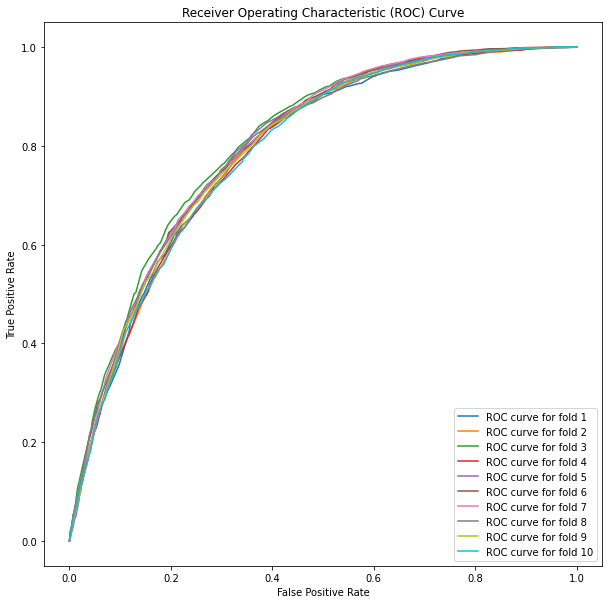

In [127]:
# Create K-Fold splitter for 10 folds
num_of_folds = 10
skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=424)

# Create Decision Tree Classifier gini model object
dtree_model = DecisionTreeClassifier(criterion = 'gini', random_state = 424)

# List of accuracy for each fold
k_fold_accuracy = []
k_fold_classification_error = []
k_fold_sensitivity = []
k_fold_precision = []
k_fold_specificity = []
k_fold_f1_score = []

auc_roc_scores = []
fpr_values = []
tpr_values = []

plt.figure(figsize=(10, 10))
# Iterate through each fold and calculate the accuracy for each fold
fold = 1

for train_index, test_index in skf.split(X,y):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit/predict on train/validation set
    y_pred = dtree_model.fit(X_train, y_train).predict(X_test)
    # -----------------------------------------------------------
    
    #confusion Matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)
    
    # Access specific values of confusion matix using [row, column]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    # Calculate accuracy for the fold and append it
    accuracy = metrics.accuracy_score(y_test, y_pred)
    k_fold_accuracy.append(round(accuracy, 4))
    #print('The accuracy for each fold is:', k_fold_accuracy)
    
    # Calculate classification error derived from accuracy (we minus it against 1) for the fold and append it
    classification_error = 1 - accuracy
    k_fold_classification_error.append(round(classification_error, 4))

    # Calculate sensitivity for the fold and append it
    sensitivity = metrics.recall_score(y_test, y_pred)
    k_fold_sensitivity.append(round(sensitivity, 4))

    # Calculate precision for the fold and append it
    precision = metrics.precision_score(y_test, y_pred)
    k_fold_precision.append(round(precision, 4))
    
    # Calculate specificity for the fold and append it
    specificity = TN / (TN + FP)
    k_fold_specificity.append(round(specificity, 4))
    
    # Calculate f1_score for the fold and append it
    f1_score = (2 * sensitivity * precision) / (sensitivity + precision)
    k_fold_f1_score.append(round(f1_score, 4))
    
    #--------------------------------------------------------------------------------------------------
    
    y_pred_proba = dtree_model.predict_proba(X_test)[:, 1]

    
    # Calculate the AUC-ROC score for this fold
    auc_roc_score = roc_auc_score(y_test, y_pred_proba)
    auc_roc_scores.append(auc_roc_score)

    # Calculate the fpr/tpr values for the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    fpr_values.append(fpr)
    tpr_values.append(tpr)
    
    
    plt.plot(fpr, tpr, label=f"ROC curve for fold {fold}")    

    fold += 1
    
print(len(auc_roc_scores))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) Curve')


##### Average AUC-ROC Curve of all folds

In [128]:
# Calculate the (1) average false positive rate, (2) average true positive rate

# Get the maximum length of the arrays in the list
max_length_fpr = max(len(a) for a in fpr_values)
max_length_tpr = max(len(a) for a in tpr_values)

# Pad each array in the list with zeros so that they have the same length
padded_fpr = np.array([np.pad(a, (0, max_length_fpr - len(a)), mode='constant') for a in fpr_values])
padded_tpr = np.array([np.pad(a, (0, max_length_tpr - len(a)), mode='constant') for a in tpr_values])

weights = [len(test_index) / len(y) for _, test_index in skf.split(X,y)]
avg_auc_roc = np.average(auc_roc_scores, weights=weights, axis=0)
avg_fpr_value = np.average(padded_fpr, weights=weights, axis=0)
avg_tpr_value = np.average(padded_tpr, weights=weights, axis=0)

# Plot AUC using area chart
fig = px.area(
    x = avg_fpr_value, y = avg_tpr_value,
    title = f'ROC Curve (AUC={avg_auc_roc:.4f})',
    labels = dict(x = 'Average False Positive Rate', y = 'Average True Positive Rate'),
    width = 700, height = 700
)

# This part adds formatting & plots the dashed line at AUC=0.5 
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [129]:
x_axis = [i for i in range(1, num_of_folds + 1)]
fig = px.scatter( x = x_axis, y = auc_roc_scores,
                 labels = {"x": "K-Fold", "y": "AUC Score"},
                 trendline = 'ols',
                 title = 'AUC Values for the the each K-Fold' # add title parameter
)

fig.show()

In [130]:
print('The average accuracy is:', statistics.mean(k_fold_accuracy))
print('The average classification error is:', statistics.mean(k_fold_classification_error))
print('The average sensitivity is:', statistics.mean(k_fold_sensitivity))
print('The average precision is:', statistics.mean(k_fold_precision))
print('The average specificity is:', statistics.mean(k_fold_specificity))
print('The average f1 score is:', statistics.mean(k_fold_f1_score))


The average accuracy is: 0.72327
The average classification error is: 0.27673000000000003
The average sensitivity is: 0.80248
The average precision is: 0.6929
The average specificity is: 0.64407
The average f1 score is: 0.74357


<hr>

### Model Evaluation 3

##### Variables Used : 
Based on RFE
<br>
Selected Num Features: 4 - ['HighBP', 'GenHlth', 'PhysHlth', 'Age']


In [131]:
# can tweak the features as needed
features = ['HighBP', 'GenHlth', 'PhysHlth', 'Age']
X = train_test_data[features]
y = train_test_data["Diabetes_binary"]

10


Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

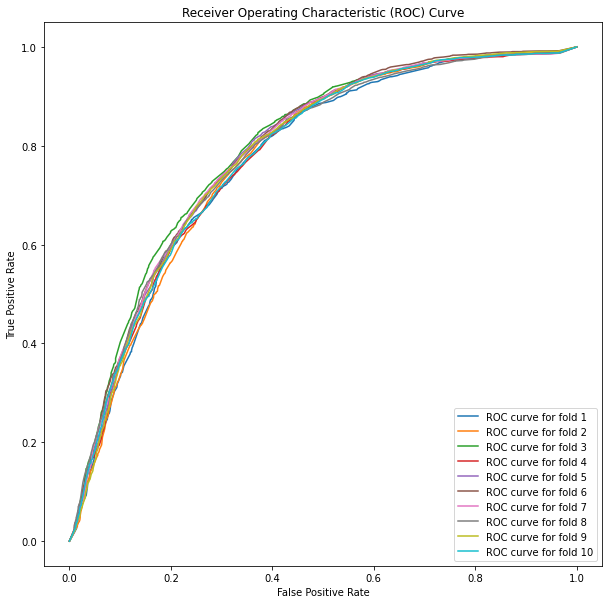

In [132]:
# Create K-Fold splitter for 10 folds
num_of_folds = 10
skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=424)

# Create Decision Tree Classifier gini model object
dtree_model = DecisionTreeClassifier(criterion = 'gini', random_state = 424)

# List of accuracy for each fold
k_fold_accuracy = []
k_fold_classification_error = []
k_fold_sensitivity = []
k_fold_precision = []
k_fold_specificity = []
k_fold_f1_score = []

auc_roc_scores = []
fpr_values = []
tpr_values = []

plt.figure(figsize=(10, 10))
# Iterate through each fold and calculate the accuracy for each fold
fold = 1

for train_index, test_index in skf.split(X,y):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit/predict on train/validation set
    y_pred = dtree_model.fit(X_train, y_train).predict(X_test)
    # -----------------------------------------------------------
    
    #confusion Matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)
    
    # Access specific values of confusion matix using [row, column]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    # Calculate accuracy for the fold and append it
    accuracy = metrics.accuracy_score(y_test, y_pred)
    k_fold_accuracy.append(round(accuracy, 4))
    #print('The accuracy for each fold is:', k_fold_accuracy)
    
    # Calculate classification error derived from accuracy (we minus it against 1) for the fold and append it
    classification_error = 1 - accuracy
    k_fold_classification_error.append(round(classification_error, 4))

    # Calculate sensitivity for the fold and append it
    sensitivity = metrics.recall_score(y_test, y_pred)
    k_fold_sensitivity.append(round(sensitivity, 4))

    # Calculate precision for the fold and append it
    precision = metrics.precision_score(y_test, y_pred)
    k_fold_precision.append(round(precision, 4))
    
    # Calculate specificity for the fold and append it
    specificity = TN / (TN + FP)
    k_fold_specificity.append(round(specificity, 4))
    
    # Calculate f1_score for the fold and append it
    f1_score = (2 * sensitivity * precision) / (sensitivity + precision)
    k_fold_f1_score.append(round(f1_score, 4))
    
    #--------------------------------------------------------------------------------------------------
    
    y_pred_proba = dtree_model.predict_proba(X_test)[:, 1]

    
    # Calculate the AUC-ROC score for this fold
    auc_roc_score = roc_auc_score(y_test, y_pred_proba)
    auc_roc_scores.append(auc_roc_score)

    # Calculate the fpr/tpr values for the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    fpr_values.append(fpr)
    tpr_values.append(tpr)
    
    
    plt.plot(fpr, tpr, label=f"ROC curve for fold {fold}")    

    fold += 1
    
print(len(auc_roc_scores))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) Curve')


##### Average AUC-ROC Curve of all folds

In [133]:
# Calculate the (1) average false positive rate, (2) average true positive rate

# Get the maximum length of the arrays in the list
max_length_fpr = max(len(a) for a in fpr_values)
max_length_tpr = max(len(a) for a in tpr_values)

# Pad each array in the list with zeros so that they have the same length
padded_fpr = np.array([np.pad(a, (0, max_length_fpr - len(a)), mode='constant') for a in fpr_values])
padded_tpr = np.array([np.pad(a, (0, max_length_tpr - len(a)), mode='constant') for a in tpr_values])

weights = [len(test_index) / len(y) for _, test_index in skf.split(X,y)]
avg_auc_roc = np.average(auc_roc_scores, weights=weights, axis=0)
avg_fpr_value = np.average(padded_fpr, weights=weights, axis=0)
avg_tpr_value = np.average(padded_tpr, weights=weights, axis=0)

# Plot AUC using area chart
fig = px.area(
    x = avg_fpr_value, y = avg_tpr_value,
    title = f'ROC Curve (AUC={avg_auc_roc:.4f})',
    labels = dict(x = 'Average False Positive Rate', y = 'Average True Positive Rate'),
    width = 700, height = 700
)

# This part adds formatting & plots the dashed line at AUC=0.5 
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [134]:
x_axis = [i for i in range(1, num_of_folds + 1)]
fig = px.scatter( x = x_axis, y = auc_roc_scores,
                 labels = {"x": "K-Fold", "y": "AUC Score"},
                 trendline = 'ols',
                 title = 'AUC Values for the the each K-Fold' # add title parameter
)

fig.show()

In [135]:
print('The average accuracy is:', statistics.mean(k_fold_accuracy))
print('The average classification error is:', statistics.mean(k_fold_classification_error))
print('The average sensitivity is:', statistics.mean(k_fold_sensitivity))
print('The average precision is:', statistics.mean(k_fold_precision))
print('The average specificity is:', statistics.mean(k_fold_specificity))
print('The average f1 score is:', statistics.mean(k_fold_f1_score))


The average accuracy is: 0.71599
The average classification error is: 0.28401
The average sensitivity is: 0.77318
The average precision is: 0.69397
The average specificity is: 0.65878
The average f1 score is: 0.73136


<hr>

### Model Evaluation 4

##### Variables Used : 
Based on RFE
<br>
Selected Num Features: 5 - ['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age']



In [136]:
# can tweak the features as needed
features = ['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age']
X = train_test_data[features]
y = train_test_data["Diabetes_binary"]

10


Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

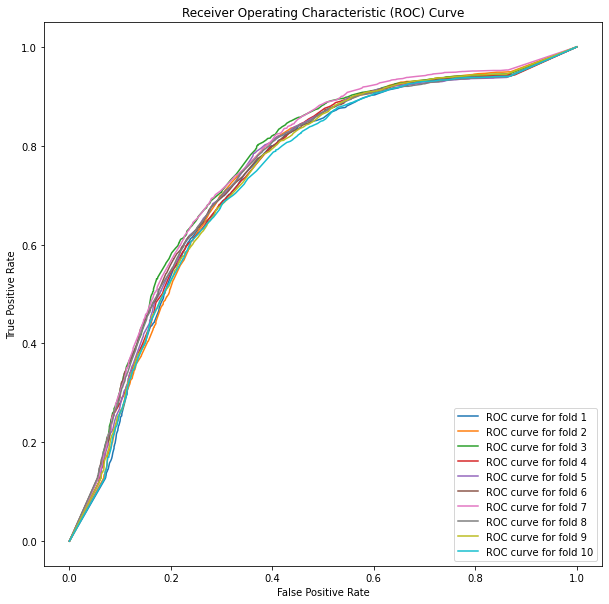

In [137]:
# Create K-Fold splitter for 10 folds
num_of_folds = 10
skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=424)

# Create Decision Tree Classifier gini model object
dtree_model = DecisionTreeClassifier(criterion = 'gini', random_state = 424)

# List of accuracy for each fold
k_fold_accuracy = []
k_fold_classification_error = []
k_fold_sensitivity = []
k_fold_precision = []
k_fold_specificity = []
k_fold_f1_score = []

auc_roc_scores = []
fpr_values = []
tpr_values = []

plt.figure(figsize=(10, 10))
# Iterate through each fold and calculate the accuracy for each fold
fold = 1

for train_index, test_index in skf.split(X,y):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit/predict on train/validation set
    y_pred = dtree_model.fit(X_train, y_train).predict(X_test)
    # -----------------------------------------------------------
    
    #confusion Matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)
    
    # Access specific values of confusion matix using [row, column]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    # Calculate accuracy for the fold and append it
    accuracy = metrics.accuracy_score(y_test, y_pred)
    k_fold_accuracy.append(round(accuracy, 4))
    #print('The accuracy for each fold is:', k_fold_accuracy)
    
    # Calculate classification error derived from accuracy (we minus it against 1) for the fold and append it
    classification_error = 1 - accuracy
    k_fold_classification_error.append(round(classification_error, 4))

    # Calculate sensitivity for the fold and append it
    sensitivity = metrics.recall_score(y_test, y_pred)
    k_fold_sensitivity.append(round(sensitivity, 4))

    # Calculate precision for the fold and append it
    precision = metrics.precision_score(y_test, y_pred)
    k_fold_precision.append(round(precision, 4))
    
    # Calculate specificity for the fold and append it
    specificity = TN / (TN + FP)
    k_fold_specificity.append(round(specificity, 4))
    
    # Calculate f1_score for the fold and append it
    f1_score = (2 * sensitivity * precision) / (sensitivity + precision)
    k_fold_f1_score.append(round(f1_score, 4))
    
    #--------------------------------------------------------------------------------------------------
    
    y_pred_proba = dtree_model.predict_proba(X_test)[:, 1]

    
    # Calculate the AUC-ROC score for this fold
    auc_roc_score = roc_auc_score(y_test, y_pred_proba)
    auc_roc_scores.append(auc_roc_score)

    # Calculate the fpr/tpr values for the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    fpr_values.append(fpr)
    tpr_values.append(tpr)
    
    
    plt.plot(fpr, tpr, label=f"ROC curve for fold {fold}")    

    fold += 1
    
print(len(auc_roc_scores))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) Curve')


##### Average AUC-ROC Curve of all folds

In [138]:
# Calculate the (1) average false positive rate, (2) average true positive rate

# Get the maximum length of the arrays in the list
max_length_fpr = max(len(a) for a in fpr_values)
max_length_tpr = max(len(a) for a in tpr_values)

# Pad each array in the list with zeros so that they have the same length
padded_fpr = np.array([np.pad(a, (0, max_length_fpr - len(a)), mode='constant') for a in fpr_values])
padded_tpr = np.array([np.pad(a, (0, max_length_tpr - len(a)), mode='constant') for a in tpr_values])

weights = [len(test_index) / len(y) for _, test_index in skf.split(X,y)]
avg_auc_roc = np.average(auc_roc_scores, weights=weights, axis=0)
avg_fpr_value = np.average(padded_fpr, weights=weights, axis=0)
avg_tpr_value = np.average(padded_tpr, weights=weights, axis=0)

# Plot AUC using area chart
fig = px.area(
    x = avg_fpr_value, y = avg_tpr_value,
    title = f'ROC Curve (AUC={avg_auc_roc:.4f})',
    labels = dict(x = 'Average False Positive Rate', y = 'Average True Positive Rate'),
    width = 700, height = 700
)

# This part adds formatting & plots the dashed line at AUC=0.5 
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [139]:
x_axis = [i for i in range(1, num_of_folds + 1)]
fig = px.scatter( x = x_axis, y = auc_roc_scores,
                 labels = {"x": "K-Fold", "y": "AUC Score"},
                 trendline = 'ols',
                 title = 'AUC Values for the the each K-Fold' # add title parameter
)

fig.show()

In [140]:
print('The average accuracy is:', statistics.mean(k_fold_accuracy))
print('The average classification error is:', statistics.mean(k_fold_classification_error))
print('The average sensitivity is:', statistics.mean(k_fold_sensitivity))
print('The average precision is:', statistics.mean(k_fold_precision))
print('The average specificity is:', statistics.mean(k_fold_specificity))
print('The average f1 score is:', statistics.mean(k_fold_f1_score))


The average accuracy is: 0.69919
The average classification error is: 0.30081
The average sensitivity is: 0.74225
The average precision is: 0.68352
The average specificity is: 0.65618
The average f1 score is: 0.71161


<hr>

### Model Evaluation 5

##### Variables Used : 
Based on RFE
<br>
Selected Num Features: 6 - ['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Income']


In [141]:
# can tweak the features as needed
features = ['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Income']
X = train_test_data[features]
y = train_test_data["Diabetes_binary"]

10


Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

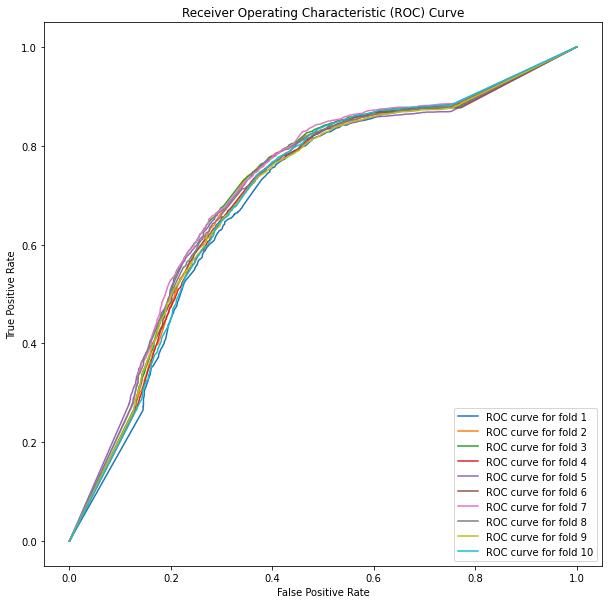

In [142]:
# Create K-Fold splitter for 10 folds
num_of_folds = 10
skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=424)

# Create Decision Tree Classifier gini model object
dtree_model = DecisionTreeClassifier(criterion = 'gini', random_state = 424)

# List of accuracy for each fold
k_fold_accuracy = []
k_fold_classification_error = []
k_fold_sensitivity = []
k_fold_precision = []
k_fold_specificity = []
k_fold_f1_score = []

auc_roc_scores = []
fpr_values = []
tpr_values = []

plt.figure(figsize=(10, 10))
# Iterate through each fold and calculate the accuracy for each fold
fold = 1

for train_index, test_index in skf.split(X,y):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit/predict on train/validation set
    y_pred = dtree_model.fit(X_train, y_train).predict(X_test)
    # -----------------------------------------------------------
    
    #confusion Matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)
    
    # Access specific values of confusion matix using [row, column]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    # Calculate accuracy for the fold and append it
    accuracy = metrics.accuracy_score(y_test, y_pred)
    k_fold_accuracy.append(round(accuracy, 4))
    #print('The accuracy for each fold is:', k_fold_accuracy)
    
    # Calculate classification error derived from accuracy (we minus it against 1) for the fold and append it
    classification_error = 1 - accuracy
    k_fold_classification_error.append(round(classification_error, 4))

    # Calculate sensitivity for the fold and append it
    sensitivity = metrics.recall_score(y_test, y_pred)
    k_fold_sensitivity.append(round(sensitivity, 4))

    # Calculate precision for the fold and append it
    precision = metrics.precision_score(y_test, y_pred)
    k_fold_precision.append(round(precision, 4))
    
    # Calculate specificity for the fold and append it
    specificity = TN / (TN + FP)
    k_fold_specificity.append(round(specificity, 4))
    
    # Calculate f1_score for the fold and append it
    f1_score = (2 * sensitivity * precision) / (sensitivity + precision)
    k_fold_f1_score.append(round(f1_score, 4))
    
    #--------------------------------------------------------------------------------------------------
    
    y_pred_proba = dtree_model.predict_proba(X_test)[:, 1]

    
    # Calculate the AUC-ROC score for this fold
    auc_roc_score = roc_auc_score(y_test, y_pred_proba)
    auc_roc_scores.append(auc_roc_score)

    # Calculate the fpr/tpr values for the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    fpr_values.append(fpr)
    tpr_values.append(tpr)
    
    
    plt.plot(fpr, tpr, label=f"ROC curve for fold {fold}")    

    fold += 1
    
print(len(auc_roc_scores))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) Curve')


##### Average AUC-ROC Curve of all folds

In [143]:
# Calculate the (1) average false positive rate, (2) average true positive rate

# Get the maximum length of the arrays in the list
max_length_fpr = max(len(a) for a in fpr_values)
max_length_tpr = max(len(a) for a in tpr_values)

# Pad each array in the list with zeros so that they have the same length
padded_fpr = np.array([np.pad(a, (0, max_length_fpr - len(a)), mode='constant') for a in fpr_values])
padded_tpr = np.array([np.pad(a, (0, max_length_tpr - len(a)), mode='constant') for a in tpr_values])

weights = [len(test_index) / len(y) for _, test_index in skf.split(X,y)]
avg_auc_roc = np.average(auc_roc_scores, weights=weights, axis=0)
avg_fpr_value = np.average(padded_fpr, weights=weights, axis=0)
avg_tpr_value = np.average(padded_tpr, weights=weights, axis=0)

# Plot AUC using area chart
fig = px.area(
    x = avg_fpr_value, y = avg_tpr_value,
    title = f'ROC Curve (AUC={avg_auc_roc:.4f})',
    labels = dict(x = 'Average False Positive Rate', y = 'Average True Positive Rate'),
    width = 700, height = 700
)

# This part adds formatting & plots the dashed line at AUC=0.5 
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [144]:
x_axis = [i for i in range(1, num_of_folds + 1)]
fig = px.scatter( x = x_axis, y = auc_roc_scores,
                 labels = {"x": "K-Fold", "y": "AUC Score"},
                 trendline = 'ols',
                 title = 'AUC Values for the the each K-Fold' # add title parameter
)

fig.show()

In [145]:
print('The average accuracy is:', statistics.mean(k_fold_accuracy))
print('The average classification error is:', statistics.mean(k_fold_classification_error))
print('The average sensitivity is:', statistics.mean(k_fold_sensitivity))
print('The average precision is:', statistics.mean(k_fold_precision))
print('The average specificity is:', statistics.mean(k_fold_specificity))
print('The average f1 score is:', statistics.mean(k_fold_f1_score))


The average accuracy is: 0.67908
The average classification error is: 0.32092
The average sensitivity is: 0.67308
The average precision is: 0.6814100000000001
The average specificity is: 0.68512
The average f1 score is: 0.67719


<hr>

### Model Evaluation 6

##### Variables Used : 
Based on RFE
<br>
Selected Num Features: 7 - ['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']


In [146]:
# can tweak the features as needed
features = ['HighBP', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
X = train_test_data[features]
y = train_test_data["Diabetes_binary"]

10


Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

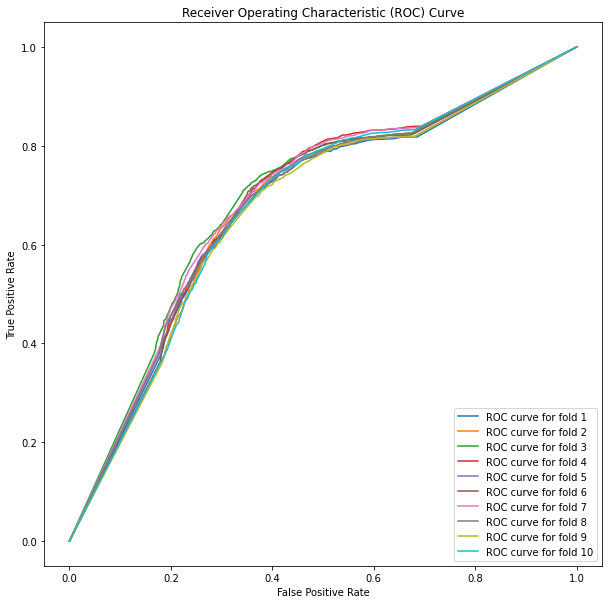

In [147]:
# Create K-Fold splitter for 10 folds
num_of_folds = 10
skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=424)

# Create Decision Tree Classifier gini model object
dtree_model = DecisionTreeClassifier(criterion = 'gini', random_state = 424)

# List of accuracy for each fold
k_fold_accuracy = []
k_fold_classification_error = []
k_fold_sensitivity = []
k_fold_precision = []
k_fold_specificity = []
k_fold_f1_score = []

auc_roc_scores = []
fpr_values = []
tpr_values = []

plt.figure(figsize=(10, 10))
# Iterate through each fold and calculate the accuracy for each fold
fold = 1

for train_index, test_index in skf.split(X,y):
    
    # Extract the training and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit/predict on train/validation set
    y_pred = dtree_model.fit(X_train, y_train).predict(X_test)
    # -----------------------------------------------------------
    
    #confusion Matrix
    confusion = metrics.confusion_matrix(y_test, y_pred)
    
    # Access specific values of confusion matix using [row, column]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    # Calculate accuracy for the fold and append it
    accuracy = metrics.accuracy_score(y_test, y_pred)
    k_fold_accuracy.append(round(accuracy, 4))
    #print('The accuracy for each fold is:', k_fold_accuracy)
    
    # Calculate classification error derived from accuracy (we minus it against 1) for the fold and append it
    classification_error = 1 - accuracy
    k_fold_classification_error.append(round(classification_error, 4))

    # Calculate sensitivity for the fold and append it
    sensitivity = metrics.recall_score(y_test, y_pred)
    k_fold_sensitivity.append(round(sensitivity, 4))

    # Calculate precision for the fold and append it
    precision = metrics.precision_score(y_test, y_pred)
    k_fold_precision.append(round(precision, 4))
    
    # Calculate specificity for the fold and append it
    specificity = TN / (TN + FP)
    k_fold_specificity.append(round(specificity, 4))
    
    # Calculate f1_score for the fold and append it
    f1_score = (2 * sensitivity * precision) / (sensitivity + precision)
    k_fold_f1_score.append(round(f1_score, 4))
    
    #--------------------------------------------------------------------------------------------------
    
    y_pred_proba = dtree_model.predict_proba(X_test)[:, 1]

    
    # Calculate the AUC-ROC score for this fold
    auc_roc_score = roc_auc_score(y_test, y_pred_proba)
    auc_roc_scores.append(auc_roc_score)

    # Calculate the fpr/tpr values for the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    fpr_values.append(fpr)
    tpr_values.append(tpr)
    
    
    plt.plot(fpr, tpr, label=f"ROC curve for fold {fold}")    

    fold += 1
    
print(len(auc_roc_scores))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) Curve')


##### Average AUC-ROC Curve of all folds

In [148]:
# Calculate the (1) average false positive rate, (2) average true positive rate

# Get the maximum length of the arrays in the list
max_length_fpr = max(len(a) for a in fpr_values)
max_length_tpr = max(len(a) for a in tpr_values)

# Pad each array in the list with zeros so that they have the same length
padded_fpr = np.array([np.pad(a, (0, max_length_fpr - len(a)), mode='constant') for a in fpr_values])
padded_tpr = np.array([np.pad(a, (0, max_length_tpr - len(a)), mode='constant') for a in tpr_values])

weights = [len(test_index) / len(y) for _, test_index in skf.split(X,y)]
avg_auc_roc = np.average(auc_roc_scores, weights=weights, axis=0)
avg_fpr_value = np.average(padded_fpr, weights=weights, axis=0)
avg_tpr_value = np.average(padded_tpr, weights=weights, axis=0)

# Plot AUC using area chart
fig = px.area(
    x = avg_fpr_value, y = avg_tpr_value,
    title = f'ROC Curve (AUC={avg_auc_roc:.4f})',
    labels = dict(x = 'Average False Positive Rate', y = 'Average True Positive Rate'),
    width = 700, height = 700
)

# This part adds formatting & plots the dashed line at AUC=0.5 
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [149]:
x_axis = [i for i in range(1, num_of_folds + 1)]
fig = px.scatter( x = x_axis, y = auc_roc_scores,
                 labels = {"x": "K-Fold", "y": "AUC Score"},
                 trendline = 'ols',
                 title = 'AUC Values for the the each K-Fold' # add title parameter
)

fig.show()

In [150]:
print('The average accuracy is:', statistics.mean(k_fold_accuracy))
print('The average classification error is:', statistics.mean(k_fold_classification_error))
print('The average sensitivity is:', statistics.mean(k_fold_sensitivity))
print('The average precision is:', statistics.mean(k_fold_precision))
print('The average specificity is:', statistics.mean(k_fold_specificity))
print('The average f1 score is:', statistics.mean(k_fold_f1_score))


The average accuracy is: 0.66459
The average classification error is: 0.33541
The average sensitivity is: 0.64431
The average precision is: 0.67163
The average specificity is: 0.68486
The average f1 score is: 0.65764


<hr>
<hr>

## Hyper Parameter Tuning
- Hyper parameter is done using Random Search CV which finds the best permutation of params within 40 iterations
- Random search cv is used as it provides a balance between quality and computation time
- <b>Validaton data set</b> is used to find the Best Parameters

In [163]:
# Best Features 
features = ['HighBP', 'GenHlth', 'Age'] #input best features
X = val_data[features]
y = val_data["Diabetes_binary"]

In [164]:
# Define the hyperparameter space
params = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 6],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

In [165]:
# Create Decision Tree Classifier gini model object
dtree_model = DecisionTreeClassifier(criterion = 'gini', random_state = 424)


# Define the Random Search CV object
random_search = RandomizedSearchCV(
    dtree_model, 
    param_distributions=params, 
    n_iter=40, 
    cv=5,
    random_state=424
)

In [166]:
# Fit the Random Search CV object to the data
random_search.fit(X, y)

# Print the best hyperparameters and the corresponding score
print('Best Hyperparameters:', random_search.best_params_)
print('Best Score:', random_search.best_score_)

Best Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'gini'}
Best Score: 0.7159956474428727


In [167]:
# Print the best hyperparameters and the corresponding score
print('Best Hyperparameters:', random_search.best_params_)
print('Best Score:', random_search.best_score_)

Best Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'gini'}
Best Score: 0.7159956474428727


## Model Evaluation using Best Features and Best Params on Unseen data

In [169]:
# Best Features 
features = ['HighBP', 'GenHlth', 'Age'] #input best variables
X = train_test_data[features] #model training
y = train_test_data["Diabetes_binary"] #model training

X_unseen = unseen_data[features] #test final model on this
y_unseen = unseen_data["Diabetes_binary"] #test final model on this
  
# Final Model with best params
final_model = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 6, criterion = 'gini')

In [171]:
plt.figure(figsize=(6, 6))

# Fit/predict on unseen data set
y_pred = final_model.fit(X, y).predict(X_unseen)
# -----------------------------------------------------------

#confusion Matrix
confusion = metrics.confusion_matrix(y_unseen, y_pred)

# Access specific values of confusion matix using [row, column]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
TP = confusion[1, 1]


# Calculate accuracy 
accuracy = metrics.accuracy_score(y_unseen, y_pred)

# Calculate classification error derived from accuracy (we minus it against 1) 
classification_error = 1 - accuracy

# Calculate sensitivity 
sensitivity = metrics.recall_score(y_unseen, y_pred)

# Calculate precision 
precision = metrics.precision_score(y_unseen, y_pred)

# Calculate specificity 
specificity = TN / (TN + FP)

# Calculate f1_score
f1_score = (2 * sensitivity * precision) / (sensitivity + precision)

#--------------------------------------------------------------------------------------------------

y_pred_proba = final_model.predict_proba(X_unseen)[:, 1]


# Calculate the AUC-ROC score
auc_roc_score = roc_auc_score(y_unseen, y_pred_proba)


# Calculate the fpr/tpr values for the ROC curve
fpr, tpr, _ = roc_curve(y_unseen, y_pred_proba)


<Figure size 432x432 with 0 Axes>

In [172]:
auc_value = metrics.auc(fpr, tpr)

# Plot AUC using area chart
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc_value:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)

# This part adds formatting & plots the dashed line at AUC=0.5 
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')


fig.show()

In [173]:
print('The accuracy on unseen data is: ', accuracy)
print('The classification_error on unseen data is: ', classification_error)
print('The sensitivity on unseen data is: ', sensitivity)
print('The precision on unseen data is: ', precision)
print('The specificity on unseen data is: ', specificity)
print('The f1_score on unseen data is: ', f1_score)

The accuracy on unseen data is:  0.7339222614840989
The classification_error on unseen data is:  0.2660777385159011
The sensitivity on unseen data is:  0.8202247191011236
The precision on unseen data is:  0.7015015015015015
The specificity on unseen data is:  0.6465149359886202
The f1_score on unseen data is:  0.7562317902233733
